# <center>Инструменты для декомпозиции временного ряда
Разделить ряд на компоненты в *Python* можно с помощью библиотеки `statsmodels`. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/AirPassengers.zip", index_col='Month', parse_dates=['Month'])
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Декомпозиция выполняется методом `seasonal_decompose()`, который принимает на вход временной ряд с одним признаком. Индексом ряда должна быть дата или время. Именно поэтому, считывая датасет, мы указываем индексом столбец `month` и приводим его к формату даты. Также, если вы знаете, что в вашем временном ряду присутствует период, его вы также можете передать в качестве параметра в `seasonal_decompose()`.

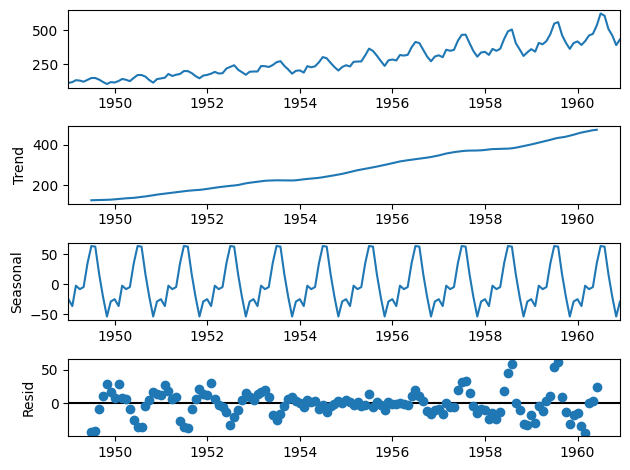

In [3]:
#импортируем библиотеку 
from statsmodels.tsa.seasonal import seasonal_decompose
#производим декомпозицию временного ряда 
decomposition = seasonal_decompose(df)
fig = decomposition.plot()
plt.show()

# <center>Экспоненциальное сглаживание

Рассмотрим **пример**.

Нам известны значения температуры за прошедший месяц, и мы хотим предсказать погоду на следующий день. Мы можем предположить, что в этом случае погода завтра в большей степени будет зависеть от погоды вчера и сегодня, чем от погоды 30 дней назад. Если мы хотим учитывать удалённость значений от текущего момента, то экспоненциальное сглаживание пригодится тут как нельзя кстати.

Так, если значения температуры за последние пять дней были `data = np.array([15, 20,25,30,25,27])` (в формуле это будет ряд  $X_t$, при этом $X_0=15$, $X_1=20$ и т. д.), а коэффициент сглаживания  будет равен $0.7$, то, подставив значения в формулу, получим значения сглаженного экспоненциального ряда: `[15. , 18.5 , 23.05 , 27.915 , 25.8745 , 26.66235]`.



In [4]:
def exp_smth(x_t, a, s_t_1):
    return a * x_t + (1 - a) * s_t_1

data = np.array([15, 20, 25, 30, 25, 27])
a = 0.7
s = np.zeros(6)
s[0] = data[0]

for i in range(1, len(data)):
    s[i] = exp_smth(data[i], a, s[i-1])

print(s)

[15.      18.5     23.05    27.915   25.8745  26.66235]


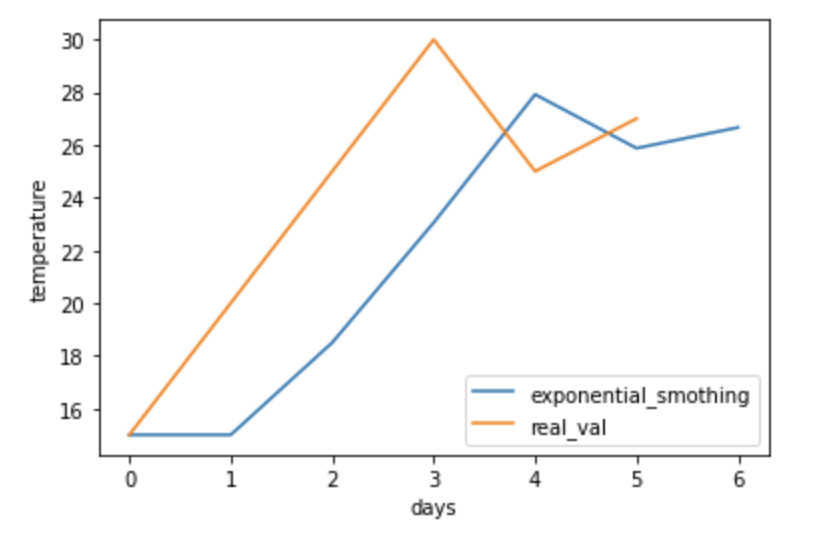

In [5]:
from statsmodels.tsa.api import SimpleExpSmoothing

ses = SimpleExpSmoothing(data)

alpha = 0.7

model = ses.fit(smoothing_level=alpha, optimized=False)

forecast = model.forecast(1)

print(forecast)


[26.66235]


# <center>Статистические тесты
Рассмотрим пример проведения теста Дики — Фуллера на данных временного ряда Daily Total Female Births. В данных содержится количественная информация о девочках, рождённых за несколько месяцев. Для проведения теста будем использовать функцию `adfuller()` из пакета `statsmodels`.

In [6]:
from statsmodels.tsa.stattools import adfuller

df = pd.read_csv(
	"data/daily-total-female-births.zip", 
    header=0, 
    index_col=0
)
display(df.head())

result = adfuller(df.values)

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:")

for key, value in result[4].items():
	print(f"\t{key}: {value:.3f}")


,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


ADF Statistic: -4.808291253559765
p-value: 5.2434129901498554e-05
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


# ЧТО ДЕЛАТЬ, ЕСЛИ РЯД НЕСТАЦИОНАРНЫЙ?

Если тест на стационарность показал, что ряд нестационарный и в нём присутствуют тренд и сезонность, необходимо избавиться от них.

Обычно для этого достаточно взять разность рядов. Разность выполняется путём **дифференцирования** ряда, для этого вычисляется разность между двумя соседними наблюдениями ряда. Если полученная первая разность ряда окажется стационарной, то этот ряд называется интегрированным рядом первого порядка.

Для определения порядка интегрированного ряда необходимо сделать следующее:
1. Получить новый ряд посредством взятия разности (применяем к необходимому датафрейму):  
    ```py
    df_diff_1 = df.diff().dropna()
    ```
2. Провести для нового ряда тест на стационарность (например, тест Дики — Фуллера): 

    ```py
    test1 = adfuller(df_diff_1)
    print ('adf: ', test1[0])
    print ('p-value: ', test1[1])
    print ('Critical values: ', test1[4])
    if test1[0] > test1[4]['5%']: 
        print ('ряд нестационарен')
    else:
        print ('ряд стационарен')
    ```

Если полученный ряд нестационарен, можно провести эту процедуру ещё раз, то есть ещё раз дифференцировать разность ряда, полученную на предыдущем этапе.

Если после двукратного дифференцирования результат окажется стационарным временным рядом, то исходный временной ряд будет называться интегрированным рядом второго порядка, и так далее.

# <center>Автокорреляция

График автокорреляций разного порядка называется коррелограмма. Его довольно просто построить с помощью метода `plot_acf` из пакета `statsmodels.graphics.tsaplots`. Методу необходимо передать всё тот же временной ряд с индексом-датой.

Воспользуемся датасетом из примера сезонной декомпозиции, в котором представлены данные о количестве авиапассажиров в 1949–1960 годах.



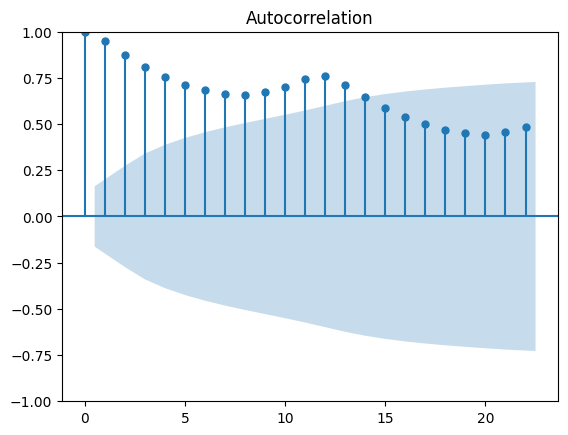

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
df = pd.read_csv("data/AirPassengers.zip", index_col='Month', parse_dates=['Month'])
plot_acf(df)
plt.show();